- competition/dataset : [https://www.kaggle.com/c/nyc-taxi-trip-duration](https://www.kaggle.com/c/nyc-taxi-trip-duration)
- date : 2021/02/23
- original : [https://www.kaggle.com/gaborfodor/from-eda-to-the-top-lb-0-367](https://www.kaggle.com/gaborfodor/from-eda-to-the-top-lb-0-367)

## From EDA to the Top (LB 0.367)

**✏ 필사 1회** 

### Introduction
이 대회에서 우리는 뉴욕 택시 이동의 총 승차 기간을 예측하는 모델을 만들어야 합니다. 이 커널에서는 feature 추출에 초점을 맞추려고 합니다. 몇 가지 kaggle과 관련된 일반적인 팁들과 모델링 개선 아이디어를 찾을 수 있을 것입니다.  

**제 목표는 주어진 커널의 한계 안에서 XGB에 대해 가능한 최상의 feature set을 만드는 것입니다.**  

이 feature들과 단일 모델로 얻은 가장 높은 점수는 LB 0.371이며, 여러 모델의 선형 조합 결과는 LB 0.368입니다. stacking은 0.367입니다.  

목차:  
* Explore the dataset
* Extract 59 useful features
* Create simple 80-20 train-validation set
* Train XGBregressor
* Analyze Feature Importance
* Score test set and submit
* Check XGB parameter search result for further improvements  

**References**  
[Nir Malbin's Kernel](https://www.kaggle.com/donniedarko/darktaxi-tripdurationprediction-lb-0-385): feature 추출 아이디어 참고  
[oscarleo's dataset](https://www.kaggle.com/oscarleo/new-york-city-taxi-with-osrm): 외부 데이터

In [36]:
%matplotlib inline
import numpy as np
import pandas as pd
from datetime import timedelta
import datetime as dt
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [16, 10]
import seaborn as sns
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.cluster import MiniBatchKMeans
import warnings
warnings.filterwarnings('ignore')

### First week progress

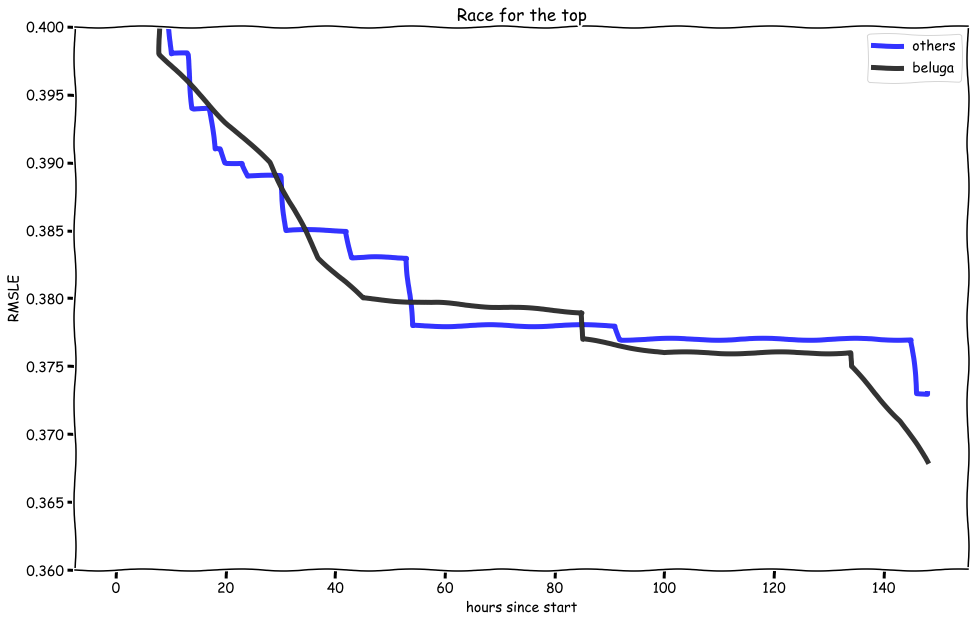

In [37]:
beluga = pd.DataFrame({'since_start_hour':[8.0, 8.0, 20.0, 28.0, 37.0, 45.0, 85.0, 85.0, 100.0, 134.0, 134.0, 143.0, 148.0],
                       'Score':[0.400,  0.398,  0.393,  0.390,  0.383,  0.380,  0.379,  0.377,  0.376,  0.376,  0.375,  0.371,  0.368]})
others = pd.DataFrame({'since_start_hour':[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,68,69,70,71,72,73,74,75,76,77,78,79,80,81,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148],
                       'BestScore':[.452,.452,.452,.452,.452,.452,.421,.421,.421,.406,.398,.398,.398,.398,.394,.394,.394,.394,.391,.391,.390,.390,.390,.390,.389,.389,.389,.389,.389,.389,.389,.385,.385,.385,.385,.385,.385,.385,.385,.385,.385,.385,.385,.383,.383,.383,.383,.383,.383,.383,.383,.383,.383,.383,.378,.378,.378,.378,.378,.378,.378,.378,.378,.378,.378,.378,.378,.378,.378,.378,.378,.378,.378,.378,.378,.378,.378,.378,.378,.378,.378,.378,.378,.378,.378,.378,.378,.378,.378,.378,.377,.377,.377,.377,.377,.377,.377,.377,.377,.377,.377,.377,.377,.377,.377,.377,.377,.377,.377,.377,.377,.377,.377,.377,.377,.377,.377,.377,.377,.377,.377,.377,.377,.377,.377,.377,.377,.377,.377,.377,.377,.377,.377,.377,.377,.377,.377,.377,.377,.377,.377,.377,.377,.377,.373,.373,.373]}) 
with plt.xkcd():
    # XKCD-style
    fig, ax = plt.subplots()
    ax.plot(others['since_start_hour'].values, others['BestScore'].values, 'b', alpha=0.8, lw=5, label='others')
    ax.plot(beluga['since_start_hour'].values, beluga['Score'].values, 'k', alpha=0.8, lw=5, label='beluga')
    ax.set_ylim(0.36, 0.4)
    ax.legend(loc=0)
    ax.set_xlabel('hours since start')
    ax.set_ylabel('RMSLE')
    ax.set_title('Race for the top')
    plt.show()

### Data understanding

In [38]:
np.random.seed(1995)
N = 100000
t0 = dt.datetime.now()
train = pd.read_csv('data/train.csv')
test = pd.read_csv('data/test.csv')
sample_submission = pd.read_csv('data/sample_submission.csv')

data description  
* **id**: 각 이동에 대한 고유 식별자  
* **vendor_id**: 이동 기록과 관련된 제공자를 나타내는 코드  
* **pickup_datetime**: 미터기가 작동된 날짜와 시간  
* **dropoff_datetime**: 미터기가 끝난 날짜와 시간  
* **passenger_count**: 탑승자 수 (운전자가 입력)  
* **pickup_longitude**: 미터기가 작동된 경도  
* **pickup_latitude**: 미터기가 작동된 위도  
* **dropoff_longitude**: 미터기가 끝난 경도
* **dropoff_latitude**: 미터기가 끝난 위도
* **store_and_fwd_flag**: 차량이 서버에 연결되지 않았기 때문에 회사에 보내기 전에 이동 기록이 차량 메모리에 저장되었는지의 여부를 나타내는 플래그 (Y=store and forward, N=not a store and forward trip)
* **trip_duration**: 이동 시간 (초 단위)  

dropoff_datetime과 trip_duration은 트레이닝 셋에만 존재합니다.

In [39]:
print('We have {} training rows and {} test rows.'.format(train.shape[0], test.shape[0]))
print('We have {} training columns and {} test columns.'.format(train.shape[1], test.shape[1]))
train.head(2)

We have 1458644 training rows and 625134 test rows.
We have 11 training columns and 9 test columns.


,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663


In [40]:
print('Id is unique.') if train.id.nunique() == train.shape[0] else print('oops')
print('Train and test sets are distinct.') if len(np.intersect1d(train.id.values, test.id.values)) == 0 else print('oops')
print('We do not need worry abount missing values.') if train.count().min() == train.shape[0] and test.count().min() == test.shape[0] else print('oops')
print('The store_and_fwd_flag has only two values {}'.format(str(set(train.store_and_fwd_flag.unique())|set(test.store_and_fwd_flag.unique()))))

Id is unique.
Train and test sets are distinct.
We do not need worry abount missing values.
The store_and_fwd_flag has only two values {'N', 'Y'}


In [41]:
# object -> datetime64[ns]
train['pickup_datetime'] = pd.to_datetime(train['pickup_datetime'])
test['pickup_datetime'] = pd.to_datetime(test['pickup_datetime'])
train['dropoff_datetime'] = pd.to_datetime(train['dropoff_datetime'])

# 날짜만 추출
train['pickup_date'] = train['pickup_datetime'].dt.date
test['pickup_date'] = test['pickup_datetime'].dt.date

# flag: Y=1, N=0
train['store_and_fwd_flag'] = 1 * (train['store_and_fwd_flag'].values == 'Y')
test['store_and_fwd_flag'] = 1 * (test['store_and_fwd_flag'].values == 'Y')

# 탑승 시간 데이터 확인
train['check_trip_duration'] = (train['dropoff_datetime'] - train['pickup_datetime']).map(lambda x: x.total_seconds())
duration_difference = train[np.abs(train['check_trip_duration'].values - train['trip_duration'].values) > 1]
print('Trip_duration and datetimes are ok.') if len(duration_difference[['pickup_datetime', 'dropoff_datetime', 'trip_duration', 'check_trip_duration']]) == 0 else print('oops')

Trip_duration and datetimes are ok.


In [42]:
# 최대 탑승 시간 (h)
train['trip_duration'].max() // 3600

979

trip_duration의 최댓값은 약 1000 시간인 것을 볼 수 있습니다. 다행히도 평가 메트릭은 RMSE가 아닌 RMSLE이며, 이상값이 문제를 덜 일으킬 것입니다. 우리는 target label을 로그변환하고 훈련하는 동안 RMSE를 사용할 수 있습니다.

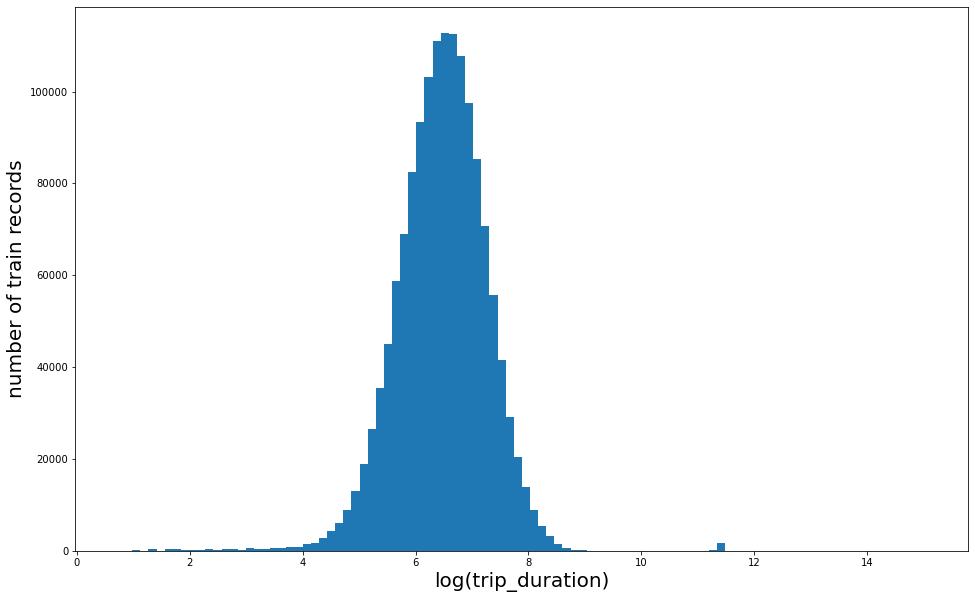

In [43]:
train['log_trip_duration'] = np.log(train['trip_duration'].values + 1)
plt.hist(train['log_trip_duration'].values, bins=100)
plt.xlabel('log(trip_duration)', size=20)
plt.ylabel('number of train records', size=20)
plt.show()

### Validation Strategy
먼저, train test split을 확인합니다. 이것은 우리의 검증 전략을 결정하는데 도움을 주며 feature engineering에 대한 아이디어를 줍니다.

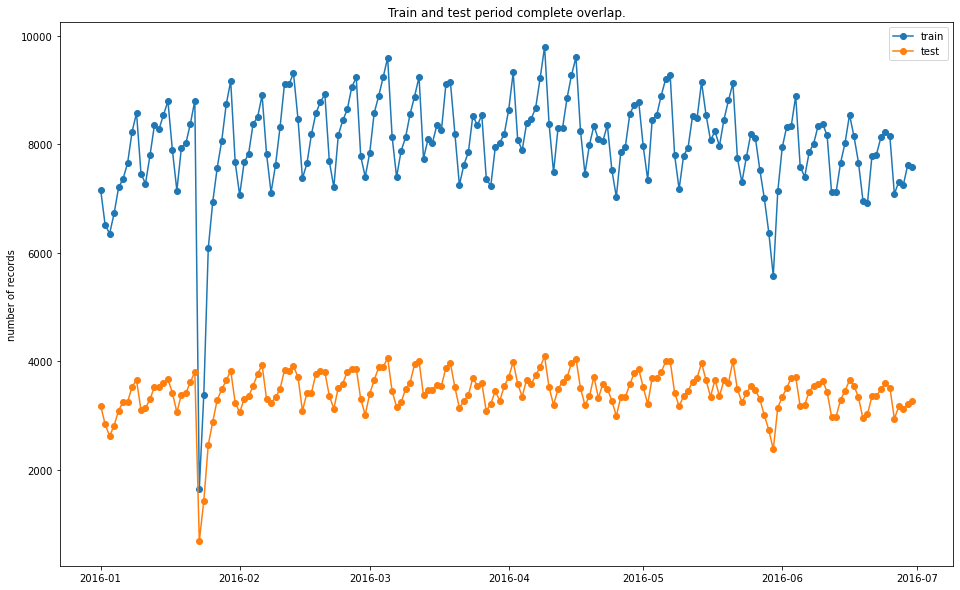

In [44]:
# pickup_date 데이터를 기준으로 날짜별 train set과 test set 건수 시각화
plt.plot(train.groupby('pickup_date').count()['id'], 'o-', label='train')
plt.plot(test.groupby('pickup_date').count()['id'], 'o-', label='test')
plt.title('Train and test period complete overlap.')
plt.ylabel('number of records')
plt.legend()
plt.show()

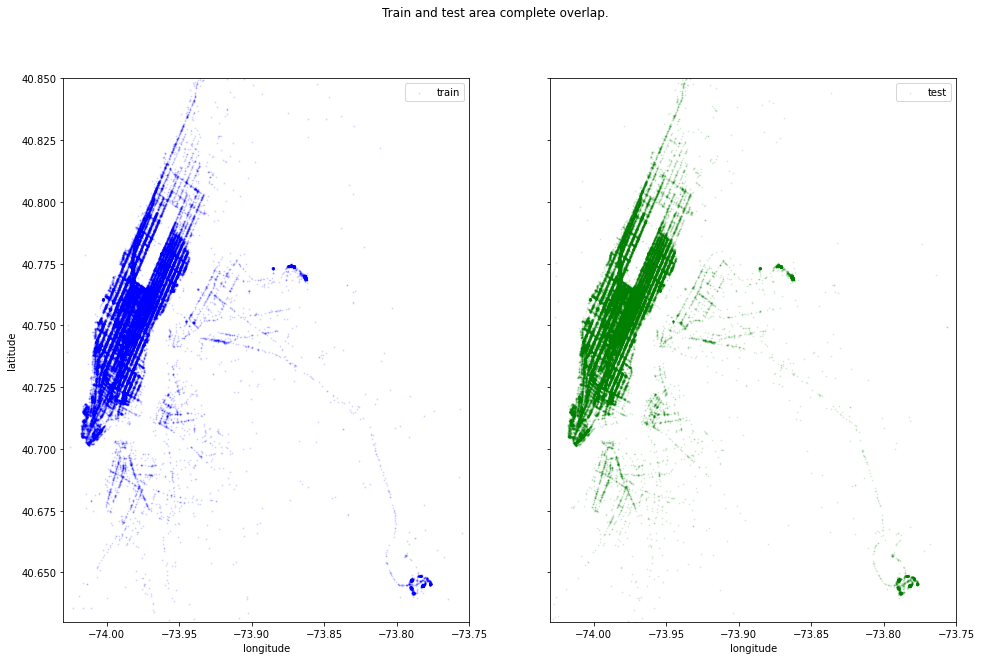

In [45]:
# N개의 좌표 분포 시각화
city_long_border = (-74.03, -73.75)
city_lat_border = (40.63, 40.85)
fig, ax = plt.subplots(ncols=2, sharex=True, sharey=True)
ax[0].scatter(
    train['pickup_longitude'].values[:N], train['pickup_latitude'].values[:N],
    color='blue', s=1, label='train', alpha=0.1
)
ax[1].scatter(
    test['pickup_longitude'].values[:N], test['pickup_latitude'].values[:N],
    color='green', s=1, label='test', alpha=0.1
)
fig.suptitle('Train and test area complete overlap.')
ax[0].set_xlabel('longitude')
ax[1].set_xlabel('longitude')
ax[0].set_ylabel('latitude')
ax[0].legend(loc=0)
ax[1].legend(loc=0)
plt.xlim(city_long_border)
plt.ylim(city_lat_border)
plt.show()

train test split이 무작위로 잘 나뉜 것으로 보입니다. 이를 통해 전체 데이터셋에 적용할 비지도 학습과 feature 추출을 사용할 수 있습니다.

### Feature Extraction

#### PCA
PCA를 사용하여 경도와 위도의 좌표를 변환합니다. 이것은 2D->2D로의 변환이기 대문에 차원 축소는 아닙니다. 회전은 의사결정나무 분할에 도움을 줄 수 있습니다.

In [46]:
coords = np.vstack((train[['pickup_latitude', 'pickup_longitude']].values,
                    train[['dropoff_latitude', 'dropoff_longitude']].values,
                    test[['pickup_latitude', 'pickup_longitude']].values,
                    test[['dropoff_latitude', 'dropoff_longitude']].values))
pca = PCA().fit(coords)
train['pickup_pca0'] = pca.transform(train[['pickup_latitude', 'pickup_longitude']])[:, 0]
train['pickup_pca1'] = pca.transform(train[['pickup_latitude', 'pickup_longitude']])[:, 1]
train['dropoff_pca0'] = pca.transform(train[['dropoff_latitude', 'dropoff_longitude']])[:, 0]
train['dropoff_pca1'] = pca.transform(train[['dropoff_latitude', 'dropoff_longitude']])[:, 1]
test['pickup_pca0'] = pca.transform(test[['pickup_latitude', 'pickup_longitude']])[:, 0]
test['pickup_pca1'] = pca.transform(test[['pickup_latitude', 'pickup_longitude']])[:, 1]
test['dropoff_pca0'] = pca.transform(test[['dropoff_latitude', 'dropoff_longitude']])[:, 0]
test['dropoff_pca1'] = pca.transform(test[['dropoff_latitude', 'dropoff_longitude']])[:, 1]

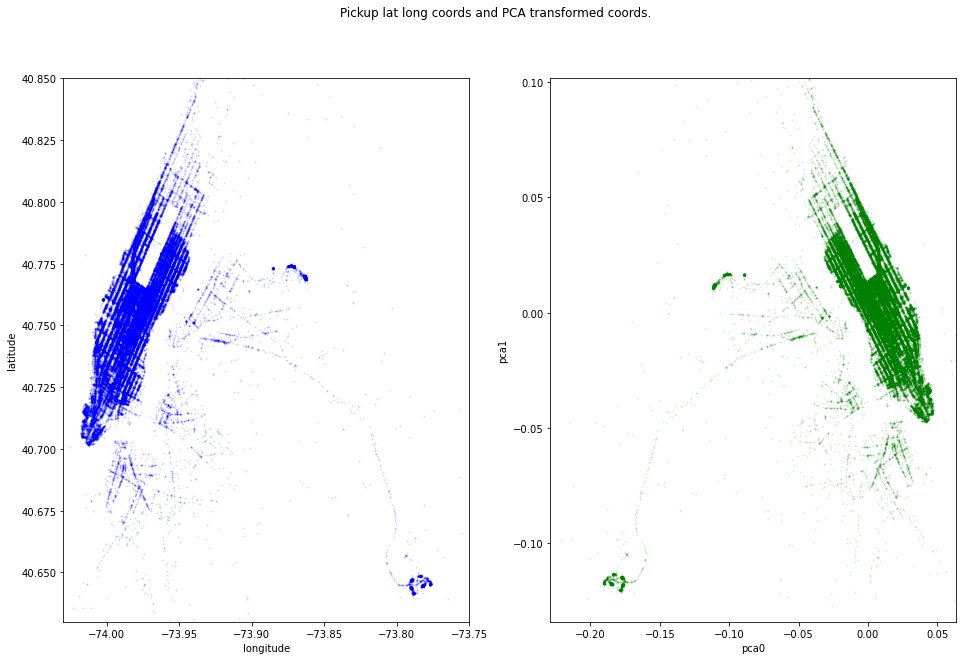

In [47]:
fig, ax = plt.subplots(ncols=2)
ax[0].scatter(
    train['pickup_longitude'].values[:N], train['pickup_latitude'].values[:N],
    color='blue', s=1, alpha=0.1
)
ax[1].scatter(
    train['pickup_pca0'].values[:N], train['pickup_pca1'].values[:N],
    color='green', s=1, alpha=0.1
)
fig.suptitle('Pickup lat long coords and PCA transformed coords.')
ax[0].set_xlabel('longitude')
ax[1].set_xlabel('pca0')
ax[0].set_ylabel('latitude')
ax[1].set_ylabel('pca1')
ax[0].set_xlim(city_long_border)
ax[0].set_ylim(city_lat_border)
pca_borders = pca.transform([[x, y] for x in city_lat_border for y in city_long_border])
ax[1].set_xlim(pca_borders[:, 0].min(), pca_borders[:, 0].max())
ax[1].set_ylim(pca_borders[:, 1].min(), pca_borders[:, 1].max())
plt.show()

#### Distance
pickup과 dropoff 점 사이의 거리(km)를 계산해봅시다. 주로 하버사인(Haversine)이 사용되며, 원한다면 geopy에 휴리스틱(heuristics)(vincenty(), great_circle())도 있습니다. 택시는 날 수 없으며 뉴욕 안에 있으므로 맨해튼(Manhattan)(L1) 거리 또한 사용할 수 있습니다.  

pd.DataFrame.apply()는 매우 느릴 수 있으므로 haversine 함수는 배열을 다루기 위해 다시 작성됩니다. 우리는 feature로서 경로의 중간값을 추출합니다.  

haversine 공식:  
$$hav(\Theta) = hav(\phi_{2} - \phi_{1}) + cos(\phi_{1})cos(\phi_{2})hav(\lambda_{2}-\lambda_{1})$$  
$\Theta$: 두 점을 잇는 호의 중심각 (라디안 단위)  
$\phi$: 위도 (라디안 단위)  
$\lambda$: 경도 (라디안 단위)  

$$hav(\theta) = sin^{2}(\frac{\theta}{2}) = \frac{1 - cos(\theta)}{2}$$  

$$d = r\,archav(h) = 2r\,arcsin(\sqrt{h})$$

In [48]:
def haversine_array(lat1, lon1, lat2, lon2):
    lat1, lon1, lat2, lon2 = map(np.radians, (lat1, lon1, lat2, lon2))
    AVG_EARTH_RADIUS = 6371  # km
    lat = lat2 - lat1
    lon = lon2 - lon1
    h = np.sin(lat * 0.5)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(lon * 0.5)**2
    d = 2 * AVG_EARTH_RADIUS * np.arcsin(np.sqrt(h))
    return d

In [49]:
def dummy_manhattan_distance(lat1, lon1, lat2, lon2):
    a = haversine_array(lat1, lon1, lat1, lon2)
    b = haversine_array(lat1, lon1, lat2, lon1)
    return a + b

In [50]:
def bearing_array(lat1, lon1, lat2, lon2):
    AVG_EARTH_RADIUS = 6371
    lon_delta_rad = np.radians(lon2 - lon1)
    lat1, lon1, lat2, lon2 = map(np.radians, (lat1, lon1, lat2, lon2))
    y = np.sin(lon_delta_rad) * np.cos(lat2)
    x = np.cos(lat1) * np.sin(lat2) - np.sin(lat1) * np.cos(lat2) * np.cos(lon_delta_rad)
    return np.degrees(np.arctan2(y, x))

In [51]:
train['distance_haversine'] = haversine_array(train['pickup_latitude'].values, train['pickup_longitude'].values, train['dropoff_latitude'].values, train['dropoff_longitude'].values)
train['distance_dummy_manhattan'] = dummy_manhattan_distance(train['pickup_latitude'].values, train['pickup_longitude'].values, train['dropoff_latitude'].values, train['dropoff_longitude'].values)
train['direction'] = bearing_array(train['pickup_latitude'].values, train['pickup_longitude'].values, train['dropoff_latitude'].values, train['dropoff_longitude'].values)
train['pca_manhattan'] = np.abs(train['dropoff_pca1'] - train['pickup_pca1']) + np.abs(train['dropoff_pca0'] - train['pickup_pca0'])

test['distance_haversine'] = haversine_array(test['pickup_latitude'].values, test['pickup_longitude'].values, test['dropoff_latitude'].values, test['dropoff_longitude'].values)
test['distance_dummy_manhattan'] = dummy_manhattan_distance(test['pickup_latitude'].values, test['pickup_longitude'].values, test['dropoff_latitude'].values, test['dropoff_longitude'].values)
test['direction'] = bearing_array(test['pickup_latitude'].values, test['pickup_longitude'].values, test['dropoff_latitude'].values, test['dropoff_longitude'].values)
test['pca_manhattan'] = np.abs(test['dropoff_pca1'] - test['pickup_pca1']) + np.abs(test['dropoff_pca0'] - test['pickup_pca0'])

train['center_latitude'] = (train['pickup_latitude'].values + train['dropoff_latitude'].values) / 2
train['center_longitude'] = (train['pickup_longitude'].values + train['dropoff_longitude'].values) / 2
test['center_latitude'] = (test['pickup_latitude'].values + test['dropoff_latitude'].values) / 2
test['center_longitude'] = (test['pickup_longitude'].values + test['dropoff_longitude'].values) / 2

#### Datetime Features

In [52]:
train['pickup_weekday'] = train['pickup_datetime'].dt.weekday
train['pickup_hour_weekofyear'] = train['pickup_datetime'].dt.weekofyear
train['pickup_hour'] = train['pickup_datetime'].dt.hour
train['pickup_minute'] = train['pickup_datetime'].dt.minute
train['pickup_dt'] = (train['pickup_datetime'] - train['pickup_datetime'].min()).dt.total_seconds()
train['pickup_week_hour'] = train['pickup_weekday'] * 24 + train['pickup_hour']

test['pickup_weekday'] = test['pickup_datetime'].dt.weekday
test['pickup_hour_weekofyear'] = test['pickup_datetime'].dt.weekofyear
test['pickup_hour'] = test['pickup_datetime'].dt.hour
test['pickup_minute'] = test['pickup_datetime'].dt.minute
test['pickup_dt'] = (test['pickup_datetime'] - test['pickup_datetime'].min()).dt.total_seconds()
test['pickup_week_hour'] = test['pickup_weekday'] * 24 + test['pickup_hour']

#### Speed

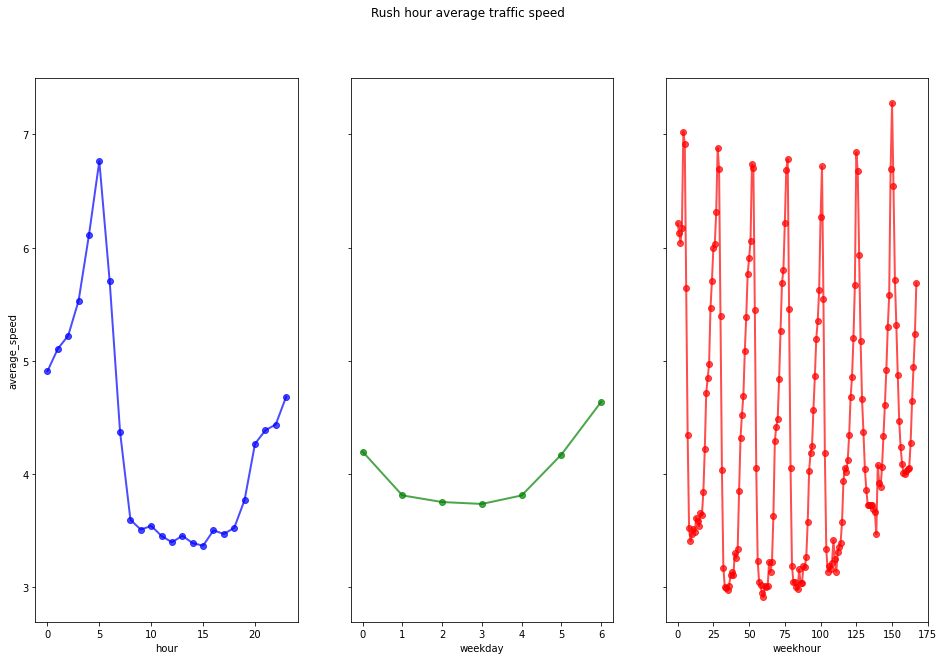

In [53]:
# hour, weekday, weekhour별 속도
train['avg_speed_h'] = 1000 * train['distance_haversine'] / train['trip_duration']
train['avg_speed_m'] = 1000 * train['distance_dummy_manhattan'] / train['trip_duration']
fig, ax = plt.subplots(ncols=3, sharey=True)
ax[0].plot(train.groupby('pickup_hour').mean()['avg_speed_h'], 'bo-', lw=2, alpha=0.7)
ax[1].plot(train.groupby('pickup_weekday').mean()['avg_speed_h'], 'go-', lw=2, alpha=0.7)
ax[2].plot(train.groupby('pickup_week_hour').mean()['avg_speed_h'], 'ro-', lw=2, alpha=0.7)
ax[0].set_xlabel('hour')
ax[1].set_xlabel('weekday')
ax[2].set_xlabel('weekhour')
ax[0].set_ylabel('average_speed')
fig.suptitle('Rush hour average traffic speed')
plt.show()

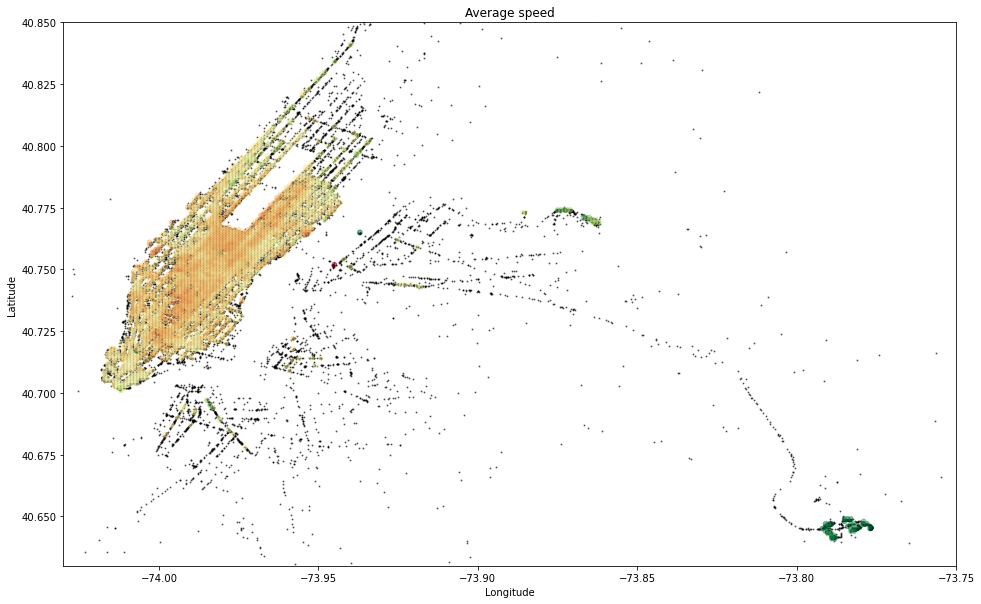

In [54]:
train['pickup_lat_bin'] = np.round(train['pickup_latitude'], 3)
train['pickup_long_bin'] = np.round(train['pickup_longitude'], 3)

# 지역별 평균 속도
gby_cols = ['pickup_lat_bin', 'pickup_long_bin']
coord_speed = train.groupby(gby_cols).mean()[['avg_speed_h']].reset_index()
coord_count = train.groupby(gby_cols).count()[['id']].reset_index()
coord_stats = pd.merge(coord_speed, coord_count, on=gby_cols)
coord_stats = coord_stats[coord_stats['id'] > 100]

fig, ax = plt.subplots(1, 1)
ax.scatter(
    train['pickup_longitude'].values[:N], train['pickup_latitude'].values[:N],
    color='black', s=1, alpha=0.5
)
ax.scatter(
    coord_stats['pickup_long_bin'].values, coord_stats['pickup_lat_bin'].values,
    c=coord_stats['avg_speed_h'].values, cmap='RdYlGn', s=20, alpha=0.5, vmin=1, vmax=8
)
ax.set_xlim(city_long_border)
ax.set_ylim(city_lat_border)
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
plt.title('Average speed')
plt.show()

In [55]:
train['pickup_lat_bin'] = np.round(train['pickup_latitude'], 2)
train['pickup_long_bin'] = np.round(train['pickup_longitude'], 2)
train['center_lat_bin'] = np.round(train['center_latitude'], 2)
train['center_long_bin'] = np.round(train['center_longitude'], 2)
train['pickup_dt_bin'] = (train['pickup_dt']//(3 * 3600))
test['pickup_lat_bin'] = np.round(test['pickup_latitude'], 2)
test['pickup_long_bin'] = np.round(test['pickup_longitude'], 2)
test['center_lat_bin'] = np.round(test['center_latitude'], 2)
test['center_long_bin'] = np.round(test['center_longitude'], 2)
test['pickup_dt_bin'] = (test['pickup_dt']//(3 * 3600))

#### Clustering

In [56]:
sample_ind = np.random.permutation(len(coords))[:500000]
kmeans = MiniBatchKMeans(n_clusters=100, batch_size=10000).fit(coords[sample_ind])

In [57]:
train['pickup_cluster'] = kmeans.predict(train[['pickup_latitude', 'pickup_longitude']])
train['dropoff_cluster'] = kmeans.predict(train[['dropoff_latitude', 'dropoff_longitude']])
test['pickup_cluster'] = kmeans.predict(test[['pickup_latitude', 'pickup_longitude']])
test['dropoff_cluster'] = kmeans.predict(test[['dropoff_latitude', 'dropoff_longitude']])
t1 = dt.datetime.now()
print('Time till clustering: %i seconds'%(t1-t0).seconds)

Time till clustering: 53 seconds


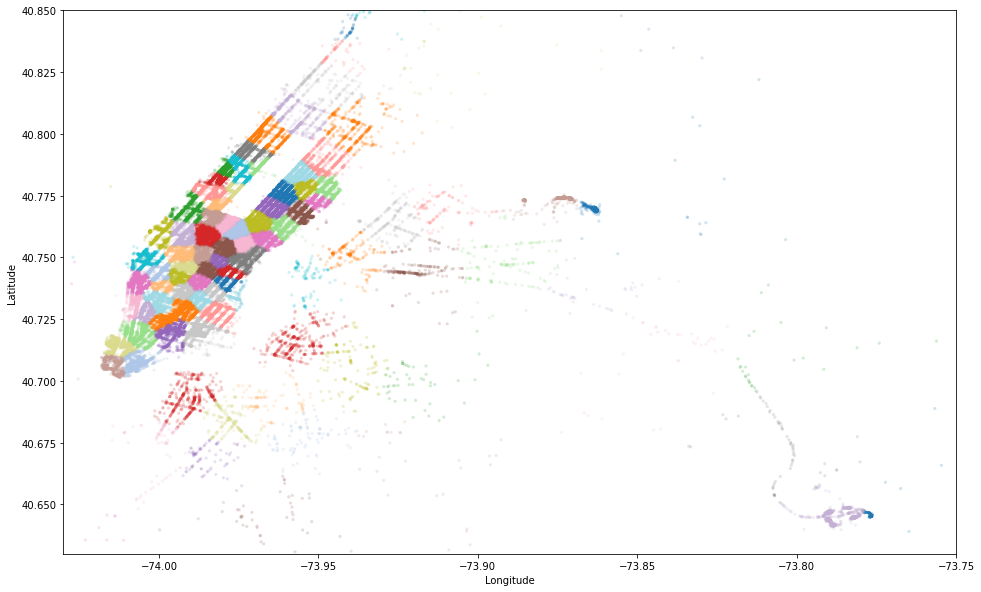

In [58]:
fig, ax = plt.subplots(1, 1)
ax.scatter(
    train['pickup_longitude'].values[:N], train['pickup_latitude'].values[:N],
    s=10, lw=0, c=train['pickup_cluster'][:N].values, cmap='tab20', alpha=0.2
)
ax.set_xlim(city_long_border)
ax.set_ylim(city_lat_border)
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
plt.show()

#### Temporal and geospatial
몇 가지 평균 트래픽 속도 feature를 추가합니다. 만약 train/test 분할이 시간 기반이라면 우리는 시간 관련 feature를 많이 사용할 수 없다는 것을 유의해야 합니다. 이 대회에서는 미래를 예측할 필요는 없습니다.

In [59]:
for gby_col in ['pickup_hour', 'pickup_date', 'pickup_dt_bin',
                'pickup_week_hour', 'pickup_cluster', 'dropoff_cluster']:
    gby = train.groupby(gby_col).mean()[['avg_speed_h', 'avg_speed_m', 'log_trip_duration']]
    gby.columns = ['%s_gby_%s' % (col, gby_col) for col in gby.columns]
    train = pd.merge(train, gby, how='left', left_on=gby_col, right_index=True)
    test = pd.merge(test, gby, how='left', left_on=gby_col, right_index=True)

In [60]:
for gby_cols in [['center_lat_bin', 'center_long_bin'],
                 ['pickup_hour', 'center_lat_bin', 'center_long_bin'],
                 ['pickup_hour', 'pickup_cluster'],
                 ['pickup_hour', 'dropoff_cluster'],
                 ['pickup_cluster', 'dropoff_cluster']]:
    coord_speed = train.groupby(gby_cols).mean()[['avg_speed_h']].reset_index()
    coord_count = train.groupby(gby_cols).count()[['id']].reset_index()
    coord_stats = pd.merge(coord_speed, coord_count, on=gby_cols)
    coord_stats = coord_stats[coord_stats['id'] > 100]
    coord_stats.columns = gby_cols + ['avg_speed_h_%s' % '_'.join(gby_cols), 'cnt_%s' %  '_'.join(gby_cols)]
    train = pd.merge(train, coord_stats, how='left', on=gby_cols)
    test = pd.merge(test, coord_stats, how='left', on=gby_cols)

In [61]:
group_freq = '60min'
# train = train.loc[:, ~train.columns.duplicated()]
# test = test.loc[:, ~test.columns.duplicated()]
df_all = pd.concat((train, test))[['id', 'pickup_datetime', 'pickup_cluster', 'dropoff_cluster']]
# df_all = pd.concat((train.loc[:, ~train.columns.duplicated()], test.loc[:, ~test.columns.duplicated()]))[['id', 'pickup_datetime', 'pickup_cluster', 'dropoff_cluster']]
train['pickup_datetime_group'] = train['pickup_datetime'].dt.round(group_freq)
test['pickup_datetime_group'] = test['pickup_datetime'].dt.round(group_freq)

In [62]:
# 60분 이상 이동 수
df_counts = df_all.set_index('pickup_datetime')[['id']].sort_index()
df_counts['count_60min'] = df_counts.isnull().rolling(group_freq).count()['id']
train = train.merge(df_counts, on='id', how='left')
test = test.merge(df_counts, on='id', how='left')

In [63]:
# 시간이 흐름에 따라 각 클러스터로 이동하는 횟수
dropoff_counts = df_all\
.groupby([pd.Grouper(key='pickup_datetime', freq=group_freq), 'dropoff_cluster'])\
.agg({'id':'count'})\
.reset_index()\
.set_index('pickup_datetime')\
.groupby('dropoff_cluster')\
.rolling('240min')\
.mean()\
.drop('dropoff_cluster', axis=1)\
.reset_index().set_index('pickup_datetime')\
.shift(freq='-120min')\
.reset_index()\
.rename(columns={
    'pickup_datetime':'pickup_datetime_group',
    'id':'dropoff_cluster_count'
})

In [64]:
cols = ['pickup_datetime_group', 'dropoff_cluster']
train['dropoff_cluster_count'] = train[cols].merge(dropoff_counts, on=cols, how='left')['dropoff_cluster_count'].fillna(0)
test['dropoff_cluster_count'] = test[cols].merge(dropoff_counts, on=cols, how='left')['dropoff_cluster_count'].fillna(0)

In [65]:
# 시간이 흐름에 따라 각 클러스터에서 이동하는 횟수
pickup_counts = df_all\
.groupby([pd.Grouper(key='pickup_datetime', freq=group_freq), 'pickup_cluster'])\
.agg({'id':'count'})\
.reset_index()\
.set_index('pickup_datetime')\
.groupby('pickup_cluster')\
.rolling('240min')\
.mean()\
.drop('pickup_cluster', axis=1)\
.reset_index().set_index('pickup_datetime')\
.shift(freq='-120min')\
.reset_index()\
.rename(columns={
    'pickup_datetime':'pickup_datetime_group',
    'id':'pickup_cluster_count'
})

In [66]:
cols = ['pickup_datetime_group', 'pickup_cluster']
train['pickup_cluster_count'] = train[cols].merge(pickup_counts, on=cols, how='left')['pickup_cluster_count'].fillna(0)
test['pickup_cluster_count'] = test[cols].merge(pickup_counts, on=cols, how='left')['pickup_cluster_count'].fillna(0)

#### OSRM Features
이전 버전에서는 대략적인 거리 추정치만 있었습니다. 이제 pickup과 dropoff 사이의 가장 빠른 경로에 대한 거리 추정치를 사용합니다.

In [67]:
fr1 = pd.read_csv(
    'data/fastest_routes_train_part_1.csv',
    usecols=['id', 'total_distance', 'total_travel_time', 'number_of_steps']
)
fr2 = pd.read_csv(
    'data/fastest_routes_train_part_2.csv',
    usecols=['id', 'total_distance', 'total_travel_time', 'number_of_steps']
)
test_street_info = pd.read_csv(
    'data/fastest_routes_test.csv',
    usecols=['id', 'total_distance', 'total_travel_time', 'number_of_steps']
)
train_street_info = pd.concat((fr1, fr2))
train = train.merge(train_street_info, how='left', on='id')
test = test.merge(test_street_info, how='left', on='id')
train_street_info.head()

,id,total_distance,total_travel_time,number_of_steps
0,id2875421,2009.1,164.9,5
1,id2377394,2513.2,332.0,6
2,id3504673,1779.4,235.8,4
3,id2181028,1614.9,140.1,5
4,id0801584,1393.5,189.4,5


In [68]:
feature_names = list(train.columns)
print(np.setdiff1d(train.columns, test.columns))
do_not_use_for_training = [
    'id', 'log_trip_duration', 'pickup_datetime', 'dropoff_datetime',
    'trip_duration', 'check_trip_duration', 'pickup_date', 'avg_speed_h',
    'avg_speed_m', 'pickup_lat_bin', 'pickup_long_bin',
    'center_lat_bin', 'center_long_bin', 'pickup_dt_bin', 'pickup_datetime_group'
]
feature_names = [f for f in train.columns if f not in do_not_use_for_training]
print('We have %i features.'%len(feature_names))
y = np.log(train['trip_duration'].values + 1)
t1 = dt.datetime.now()
print('Feature extraction time: %i seconds'%(t1-t0).seconds)

['avg_speed_h' 'avg_speed_m' 'check_trip_duration' 'dropoff_datetime'
 'log_trip_duration' 'trip_duration']
We have 59 features.
Feature extraction time: 170 seconds


#### Feature check before modeling
모델링 전에 트레이닝과 테스트 feature 분포를 확인하는 것이 두통을 줄여줄 수 있습니다. 일반적으로 kaggle 대회에서 트레이닝 셋과 테스트 셋은 독립균등분포(IID, Independent Identically Distribution)입니다. 만약 트레이닝 셋과 테스트 셋 사이에 큰 차이가 있다면 아마 feature 추출 파이프라인에서 버그가 발생할 것입니다.

In [69]:
feature_stats = pd.DataFrame({'feature':feature_names})
feature_stats['train_mean'] = np.nanmean(train[feature_names].values, axis=0).round(4)
feature_stats['test_mean'] = np.nanmean(test[feature_names].values, axis=0).round(4)
feature_stats['train_std'] = np.nanstd(train[feature_names].values, axis=0).round(4)
feature_stats['test_std'] = np.nanstd(test[feature_names].values, axis=0).round(4)
feature_stats['train_nan'] = np.mean(np.isnan(train[feature_names].values), axis=0).round(3)
feature_stats['test_nan'] = np.mean(np.isnan(test[feature_names].values), axis=0).round(3)
feature_stats['train_test_mean_diff'] = np.abs(feature_stats['train_mean'] - feature_stats['test_mean']) / np.abs(feature_stats['train_std'] + feature_stats['test_std']) * 2
feature_stats['train_test_nan_diff'] = np.abs(feature_stats['train_nan'] - feature_stats['test_nan'])
feature_stats = feature_stats.sort_values(by='train_test_mean_diff')
feature_stats[['feature', 'train_test_mean_diff']].tail()

,feature,train_test_mean_diff
21,pickup_dt,0.002647
7,pickup_pca0,0.002774
10,dropoff_pca1,0.002833
18,pickup_hour_weekofyear,0.002872
51,avg_speed_h_pickup_cluster_dropoff_cluster,0.003619


In [70]:
feature_stats = feature_stats.sort_values(by='train_test_nan_diff')
feature_stats[['feature', 'train_nan', 'test_nan', 'train_test_nan_diff']].tail()

,feature,train_nan,test_nan,train_test_nan_diff
39,log_trip_duration_gby_pickup_cluster,0.000,0.000,0.000
27,log_trip_duration_gby_pickup_hour,0.000,0.000,0.000
46,cnt_pickup_hour_center_lat_bin_center_long_bin,0.081,0.081,0.000
52,cnt_pickup_cluster_dropoff_cluster,0.107,0.110,0.003
51,avg_speed_h_pickup_cluster_dropoff_cluster,0.107,0.110,0.003


위에서 평균 차이는 표준 편차의 1% 미만입니다. 약간의 결측값들이 존재하지만 결측 비율은 동일합니다. 다행히도 xgboost가 결측값을 처리할 수 있습니다.

### Modeling

In [71]:
xtr, xv, ytr, yv = train_test_split(train[feature_names].values, y, test_size=0.2, random_state=1995)
dtrain = xgb.DMatrix(xtr, label=ytr)
dvalid = xgb.DMatrix(xv, label=yv)
dtest = xgb.DMatrix(test[feature_names].values)
watchlist = [(dtrain, 'train'), (dvalid, 'valid')]

# 파라미터 설정
xgb_pars = {
    'min_child_weight':50,
    'eta':0.3,
    'colsample_bytree':0.3,
    'max_depth':10,
    'subsample':0.8,
    'lambda':1.,
    'nthread':4,
    'booster':'gbtree',
    'silent':1,
    'eval_metric':'rmse',
    'objective':'reg:linear'
}

In [72]:
# epoch값 늘려도 됨
model = xgb.train(xgb_pars, dtrain, 100, watchlist, early_stopping_rounds=50,
                  maximize=False, verbose_eval=10)

[14:53:43] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[14:53:44] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	train-rmse:4.23234	valid-rmse:4.23121
[10]	train-rmse:0.40346	valid-rmse:0.40777
[20]	train-rmse:0.37158	valid-rmse:0.38224
[30]	train-rmse:0.36346	valid-rmse:0.37931
[40]	train-rmse:0.35780	valid-rmse:0.37825
[50]	train-rmse:0.35466	valid-rmse:0.37749
[60]	train-rmse:0.35075	valid-rmse:0.37719
[70]	train-rmse:0.34753	valid-rmse:0.37698
[80]	train-rmse:0.34448	valid-rmse:0.37665
[90]	train-rmse:0.34195	valid-rmse:0.37670
[99]	train

In [73]:
print('Model RMSLE %.5f'%model.best_score)
t1 = dt.datetime.now()
print('Training time: %i seconds'%(t1-t0).seconds)

Model RMSLE 0.37660
Training time: 525 seconds


### Feature importance analysis
xgboost 모델은 각 변수가 얼마나 사용되었는지에 대한 변수 중요도 점수를 가집니다. 변수가 실제로 매우 중요하다는 것을 의미하는 것이 아니라 높은 점수일수록 트리 분배에 더 많이 사용되었음을 의미한다는 사실을 기억해야 합니다. 강한 상관관계를 가지거나 cardinality가 높은 feature가 결과에 영향을 줍니다.  

저는 간단한 후진제거법을 시도해보았습니다. 각 feature마다 새로운 모델은 해당 feature를 제외하고 훈련됩니다. 이를 통해 제거해서는 안되는 필수적인 feature가 어떤 것인지 알 수 있습니다. 56개의 모델을 교육하는데 몇 시간이 걸리므로 오프라인 검증 결과를 사용합니다.  

OSRM feature는 나중에 추가되었으므로 다음 내용에는 포함되어 있지 않습니다. 따라서 해당 feature들은 중요한 변수라고 가정하겠습니다.

In [74]:
rmse_wo_feature = [0.39224, 0.38816, 0.38726, 0.38780, 0.38773, 0.38792, 0.38753, 0.38745, 0.38710, 0.38767, 0.38738, 0.38750, 0.38678, 0.39359, 0.38672, 0.38794, 0.38694, 0.38750, 0.38742, 0.38673, 0.38754, 0.38705, 0.38736, 0.38741, 0.38764, 0.38730, 0.38676, 0.38696, 0.38750, 0.38705, 0.38746, 0.38727, 0.38750, 0.38771, 0.38747, 0.38907, 0.38719, 0.38756, 0.38701, 0.38734, 0.38782, 0.38673, 0.38797, 0.38720, 0.38709, 0.38704, 0.38809, 0.38768, 0.38798, 0.38849, 0.38690, 0.38753, 0.38721, 0.38807, 0.38830, 0.38750, np.nan, np.nan, np.nan]
feature_importance_dict = model.get_fscore()
fs = ['f%i'%i for i in range(len(feature_names))]
f1 = pd.DataFrame({
    'f':list(feature_importance_dict.keys()),
    'importance':list(feature_importance_dict.values())
})
f2 = pd.DataFrame({
    'f':fs,
    'feature_name':feature_names,
    'rmse_wo_feature':rmse_wo_feature
})
feature_importance = pd.merge(f1, f2, how='right', on='f')
feature_importance.fillna(0, inplace=True)
feature_importance[['feature_name', 'importance', 'rmse_wo_feature']].sort_values('importance', ascending=False)

,feature_name,importance,rmse_wo_feature
13,direction,1222,0.39359
12,distance_dummy_manhattan,1202,0.38678
8,pickup_pca1,1046,0.38710
9,dropoff_pca0,977,0.38767
57,total_travel_time,933,0.00000
11,distance_haversine,920,0.38750
10,dropoff_pca1,906,0.38738
14,pca_manhattan,899,0.38672
2,pickup_longitude,873,0.38726
7,pickup_pca0,866,0.38745


다음 플롯은 feature 제거 결과와 xgboost 중요도를 보여줍니다.  
* 변수 중요도가 높은 위치 관련 변수들은 꽤 많았지만, 그 중 하나를 제거한다고 해서 오류가 증가하지는 않았습니다.
* 변수 중요도 플롯에 의하면 vendor_id는 두 번째로 적게 사용된 변수이지만 해당 변수를 제거했을 때 rmse가 매우 증가했습니다. 이 변수는 이진 값이며, 심지어 이것을 사용하는 몇 개의 의사결정 나무들도 이 정보를 사용합니다.  
* direction은 두 측면에서 모두 중요합니다. 이 변수는 다른 변수들과 상관 관계를 크게 가지지 않으며, 제거 시 모델이 많이 손상됩니다.
* 제거가 가능한 변수들이 많습니다.

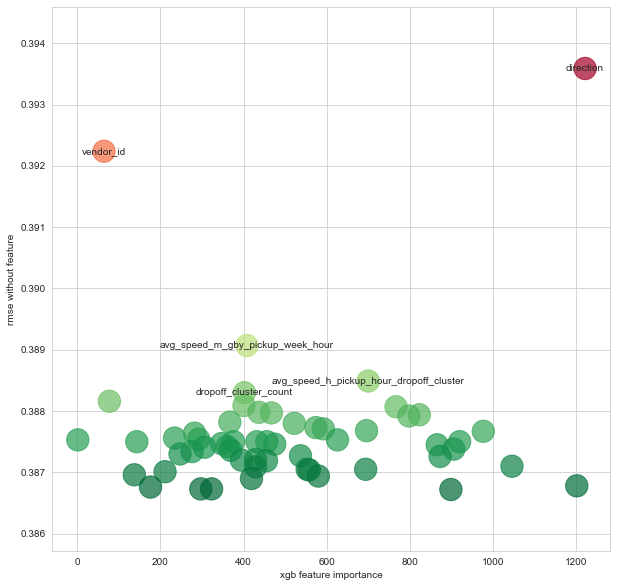

In [75]:
feature_importance = feature_importance.sort_values('rmse_wo_feature', ascending=False)
feature_importance = feature_importance[feature_importance['rmse_wo_feature'] > 0]
with sns.axes_style('whitegrid'):
    fig, ax = plt.subplots(figsize=(10, 10))
    ax.scatter(
        feature_importance['importance'].values, feature_importance['rmse_wo_feature'].values,
        c=feature_importance['rmse_wo_feature'].values, s=500, cmap='RdYlGn_r', alpha=0.7
    )
    for _, row in feature_importance.head(5).iterrows():
        ax.text(
            row['importance'], row['rmse_wo_feature'], row['feature_name'],
            verticalalignment='center', horizontalalignment='center'
        )
    ax.set_xlabel('xgb feature importance')
    ax.set_ylabel('rmse without feature')
    ax.set_ylim(np.min(feature_importance['rmse_wo_feature']) - 0.001,
                np.max(feature_importance['rmse_wo_feature']) + 0.001)
    plt.show()

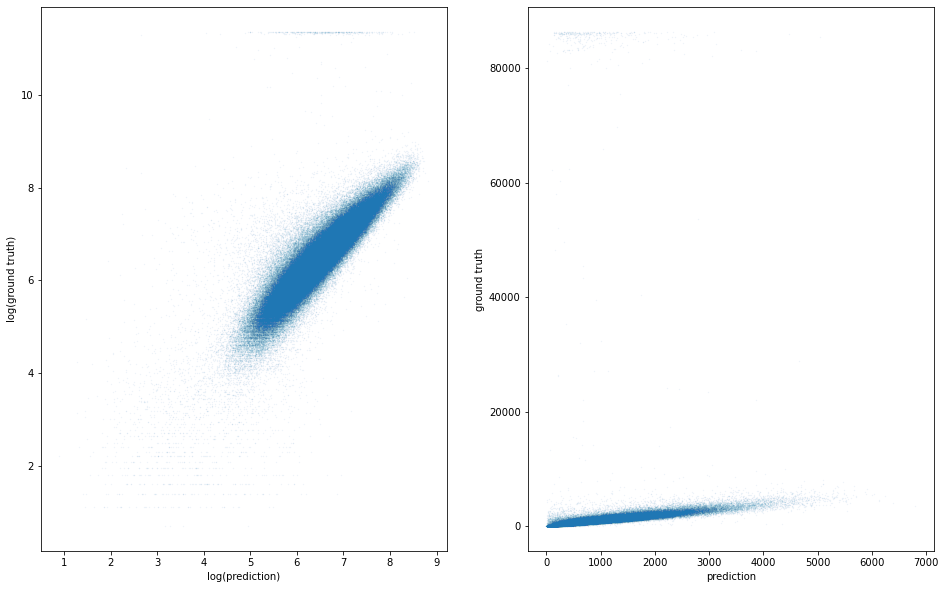

In [76]:
ypred = model.predict(dvalid)
fig, ax = plt.subplots(ncols=2)
ax[0].scatter(ypred, yv, s=0.1, alpha=0.1)
ax[0].set_xlabel('log(prediction)')
ax[0].set_ylabel('log(ground truth)')
ax[1].scatter(np.exp(ypred), np.exp(yv), s=0.1, alpha=0.1)
ax[1].set_xlabel('prediction')
ax[1].set_ylabel('ground truth')
plt.show()

### Submission: LB 0.38893
이제 로그 기간을 다시 변환한 뒤 제출 파일을 저장합니다.  

검증과 테스트 예측 결과의 분포를 확인해보면, iid 분할 때문에 두 분포는 같아야 합니다. 이전 제출물과의 상관관계를 확인해보면 더욱 신뢰를 얻을 수 있습니다.

In [78]:
ytest = model.predict(dtest)
print('Test shape OK.') if test.shape[0] == ytest.shape[0] else print('Oops')
test['trip_duration'] = np.exp(ytest) - 1
test[['id', 'trip_duration']].to_csv('data/submission_1_beluga_xgb.csv', index=False)

print('Valid prediction mean: %.3f'%ypred.mean())
print('Test prediction mean: %.3f'%ytest.mean())

Test shape OK.
Valid prediction mean: 6.467
Test prediction mean: 6.466


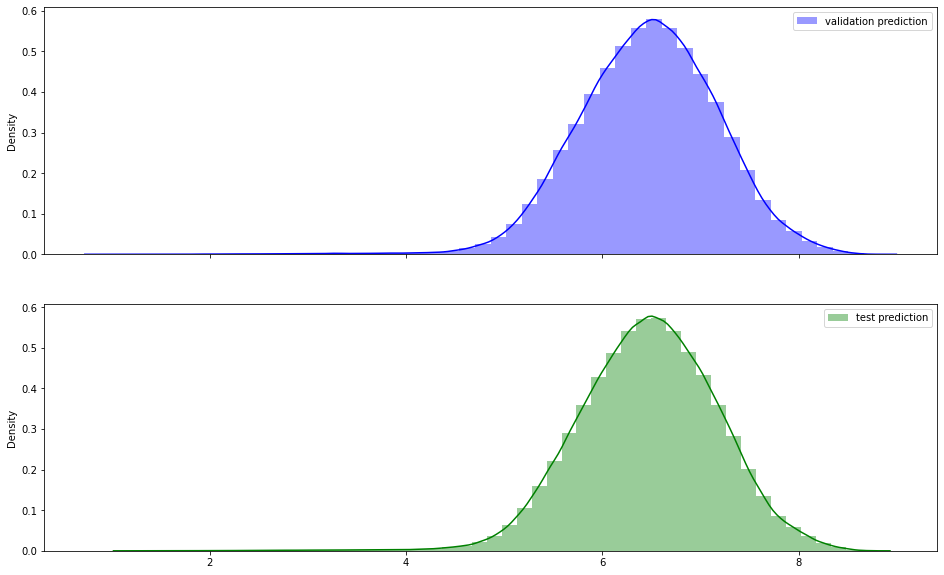

Total time: 1425 seconds


In [81]:
fig, ax = plt.subplots(nrows=2, sharex=True, sharey=True)
sns.distplot(ypred, ax=ax[0], color='blue', label='validation prediction')
sns.distplot(ytest, ax=ax[1], color='green', label='test prediction')
ax[0].legend(loc=0)
ax[1].legend(loc=0)
plt.show()

t1 = dt.datetime.now()
print('Total time: %i seconds'%(t1-t0).seconds)

### XGB Parameter Search Result
파라미터 튜닝을 위해 random search를 선호합니다. 일반적으로 다음 파라미터들의 다양한 값을 시도해봅니다:  
* min_child_weight
* eta
* colsample_bytree
* max_depth
* subsample
* lambda

sklearn의 CV 옵션(RandomizedSearchCV or GridSearchCV)을 선호하지만 일반 대회에서 단일 모델에 대한 훈련은 몇 시간씩 걸리므로 중간 결과를 저장하고자 합니다(성능 메트릭, oof 예측 등). 커스텀 함수를 사용하며, 결과에 따라 grid searchpoint를 수동으로 설정하고자 합니다.

In [82]:
FOREVER_COMPUTING_FLAG = False
xgb_pars = []
for MCW in [10, 20, 50, 75, 100]:
    for ETA in [0.05, 0.1, 0.15]:
        for CS in [0.3, 0.4, 0.5]:
            for MD in [6, 8, 10, 12, 15]:
                for SS in [0.5, 0.6, 0.7, 0.8, 0.9]:
                    for LAMBDA in [0.5, 1., 1.5, 2., 3.]:
                        xgb_pars.append({
                            'min_child_weight':MCW,
                            'eta':ETA,
                            'colsample_bytree':CS,
                            'max_depth':MD,
                            'subsample':SS,
                            'lambda':LAMBDA,
                            'nthread':-1,
                            'booster':'gbtree',
                            'eval_metric':'rmse',
                            'silent':1,
                            'objective':'reg:linear'
                        })
while FOREVER_COMPUTING_FLAG:
    xgb_par = np.random.choise(xgb_pars, 1)[0]
    print(xgb_par)
    model = xgb.train(
        xgb_par, dtrain, 2000, watchlist, early_stopping_rounds=50,
        maximize=False, verbose_eval=100
    )
    print('Modeling RMSLE %.5f'%model.best_score)

이러한 실험은 커널 한계를 뛰어 넘으므로 결과를 아래에 복사했습니다.

In [83]:
paropt = pd.DataFrame({
    'lambda':[1.5,1.0,1.0,1.5,1.5,1.0,1.5,1.0,1.5,2.0,0.5,1.0,0.5,1.5,1.5,0.5,1.0,1.5,0.5,2.0,1.0,2.0,2.0,1.5,1.5,2.0,1.5,2.0,1.5,0.5,1.0,1.0,2.0,1.5,1.0,1.0,0.5,2.0,1.0,0.5,0.5,2.0,1.0,1.0,0.5,0.5,1.5,0.5,1.5,2.0,2.0,2.0,2.0,0.5,1.5,1.0,1.5,2.0,2.0,0.5,1.5,1.0,0.5,1.0,1.5,2.0,1.0,1.0,2.0,2.0,1.0,0.5,0.5,1.0,1.5,2.0,0.5,1.0,1.5,1.0,1.0,1.5,1.5,1.5,0.5,1.5,1.0,1.5,2.0,2.0,2.0,1.0,2.0,0.5,2.0,0.5,1.5,0.5,2.0,0.5,1.0,1.5,1.5,1.5,2.0,0.5,0.5,1.0,2.0],
    'eta':[.1,.1,.05,.05,.05,.15,.15,.1,.1,.05,.15,.15,.15,.1,.1,.1,.1,.05,.15,.05,.05,.05,.15,.15,.05,.05,.05,.05,.15,.15,.15,.15,.1,.05,.05,.1,.1,.1,.1,.1,.05,.15,.15,.15,.1,.1,.05,.05,.15,.15,.15,.1,.1,.05,.05,.05,.05,.05,.15,.1,.1,.15,.1,.1,.05,.15,.15,.15,.1,.05,.05,.05,.05,.15,.1,.1,.1,.1,.05,.05,.05,.15,.15,.1,.1,.1,.1,.05,.15,.15,.1,.1,.1,.05,.05,.1,.1,.1,.1,.1,.05,.15,.15,.15,.15,.05,.05,.15,.15],
    'min_child_weight': [50,50,20,100,10,50,100,100,75,10,10,50,50,100,75,100,50,10,20,10,75,20,50,75,100,100,10,20,75,75,75,20,10,75,10,100,100,10,20,20,50,50,100,20,50,100,100,75,20,75,20,50,20,10,20,20,20,75,20,75,100,10,10,20,10,20,100,75,75,10,100,50,100,100,50,10,75,75,50,10,75,75,50,75,20,100,100,50,20,20,50,50,75,20,50,100,75,75,100,75,10,10,20,20,10,10,75,50,20],
    'subsample':[.8,.9,.8,.6,.6,.6,.9,.6,.5,.9,.8,.9,.7,.5,.5,.9,.7,.7,.5,.8,.5,.9,.6,.6,.8,.8,.8,.7,.5,.5,.9,.9,.5,.6,.7,.8,.8,.6,.9,.7,.8,.6,.6,.9,.7,.7,.8,.6,.6,.5,.9,.8,.7,.6,.6,.6,.5,.9,.8,.5,.7,.6,.8,.6,.8,.8,.6,.7,.9,.5,.7,.5,.9,.7,.8,.9,.9,.7,.8,.5,.7,.8,.6,.8,.8,.5,.9,.5,.5,.7,.8,.6,.6,.8,.7,.6,.6,.6,.7,.7,.8,.6,.5,.9,.7,.6,.9,.5,.5],
    'rmse': [.380,.380,.377,.378,.378,.386,.382,.382,.383,.374,.386,.381,.385,.383,.383,.379,.381,.376,.389,.375,.381,.374,.385,.385,.378,.377,.375,.376,.385,.386,.382,.384,.384,.379,.376,.380,.380,.382,.380,.382,.378,.385,.384,.383,.383,.383,.379,.381,.386,.387,.381,.380,.380,.377,.377,.377,.379,.376,.382,.385,.382,.386,.380,.382,.375,.383,.385,.384,.379,.378,.380,.381,.378,.384,.380,.377,.379,.383,.380,.380,.380,.383,.385,.381,.379,.386,.380,.383,.387,.383,.382,.384,.385,.377,.380,.383,.383,.383,.382,.382,.377,.386,.388,.382,.384,.379,.378,.387,.388]
})

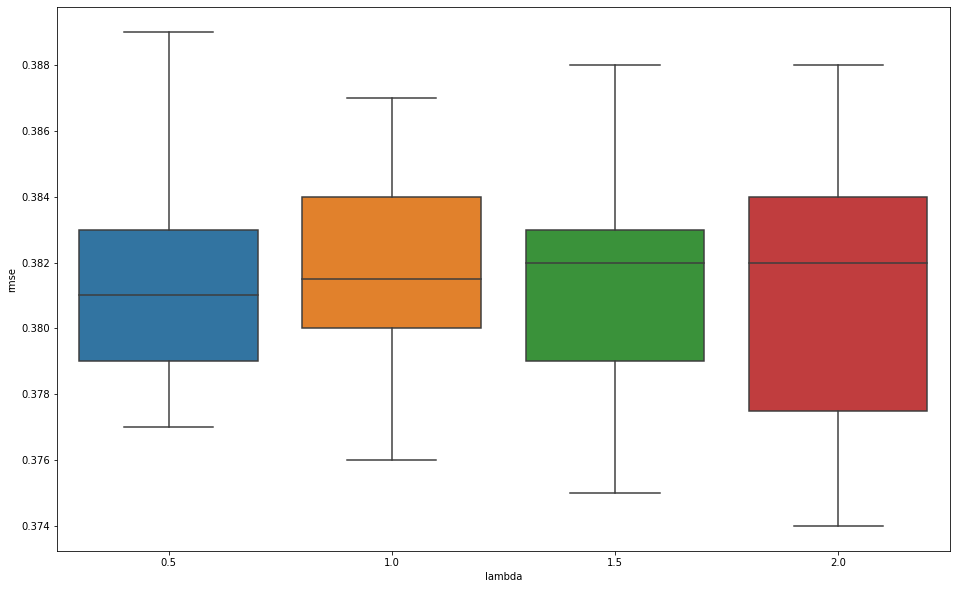

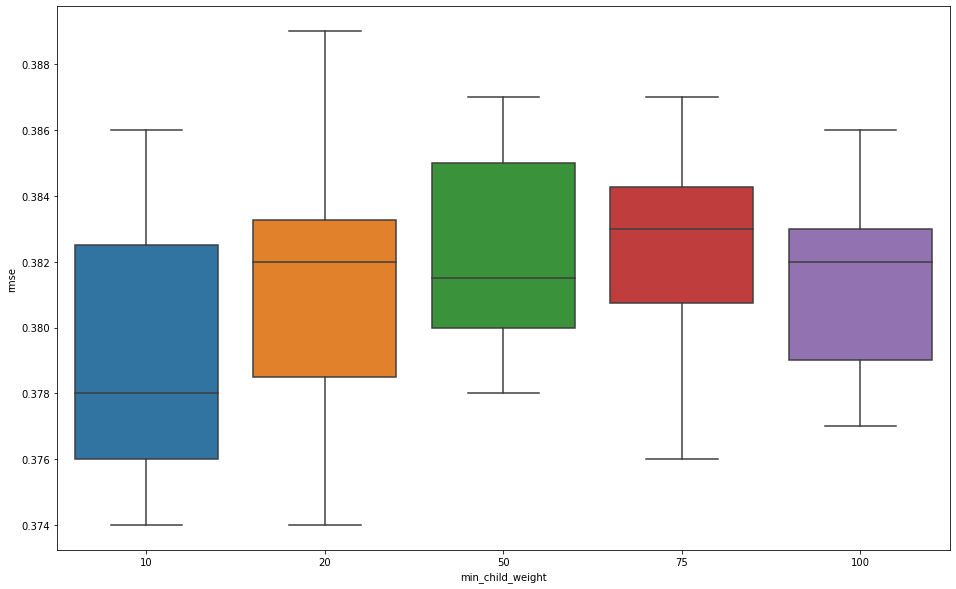

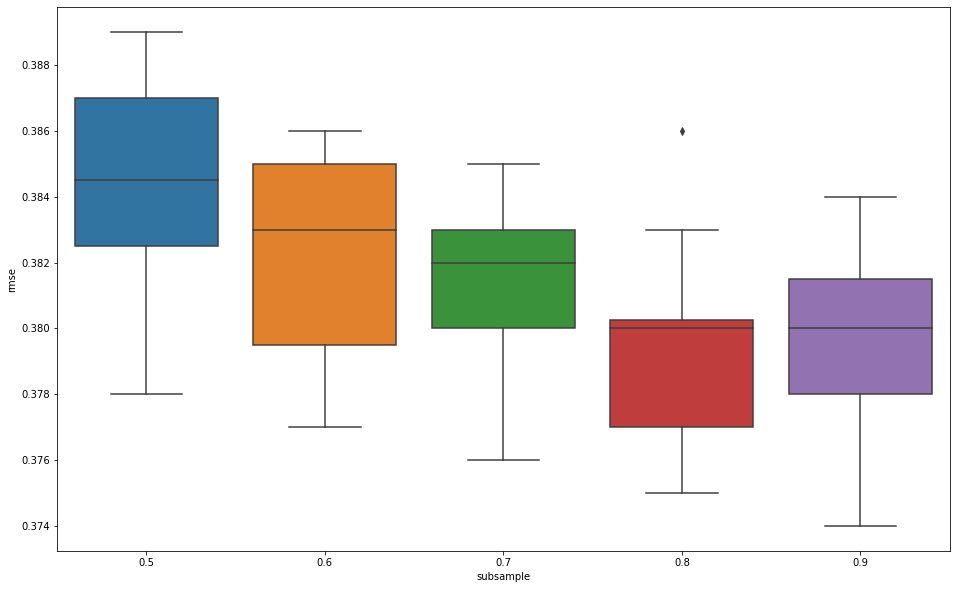

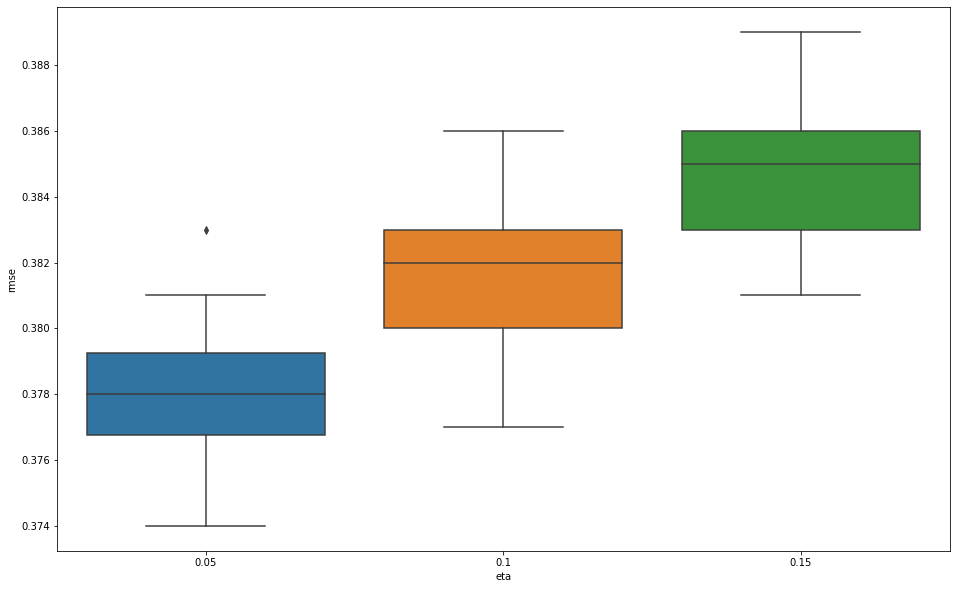

In [84]:
for i, par in enumerate(['lambda', 'min_child_weight', 'subsample', 'eta']):
    fig, ax = plt.subplots()
    ax = sns.boxplot(x=par, y='rmse', data=paropt)

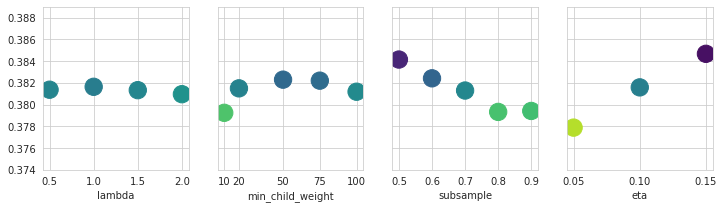

In [85]:
with sns.axes_style("whitegrid"):
    fig, axs = plt.subplots(ncols=4, sharey=True, figsize=(12, 3))
    for i, par in enumerate(['lambda', 'min_child_weight', 'subsample', 'eta']):
        mean_rmse = paropt.groupby(par).mean()[['rmse']].reset_index()
        axs[i].scatter(
            mean_rmse[par].values, mean_rmse['rmse'].values, c=mean_rmse['rmse'].values,
            s=300, cmap='viridis_r', vmin=.377, vmax=.385, )
        axs[i].set_xlabel(par)
        axs[i].set_xticks(mean_rmse[par].values)
        axs[i].set_ylim(paropt.rmse.min(), paropt.rmse.max())

### Cross Validation Test
위에서 LB 제출 결과보다 더 좋은 점수가 나온 적이 있습니다. 우리의 전체 결과물들을 확인해보겠습니다.

CV - LB Diff: 0.005


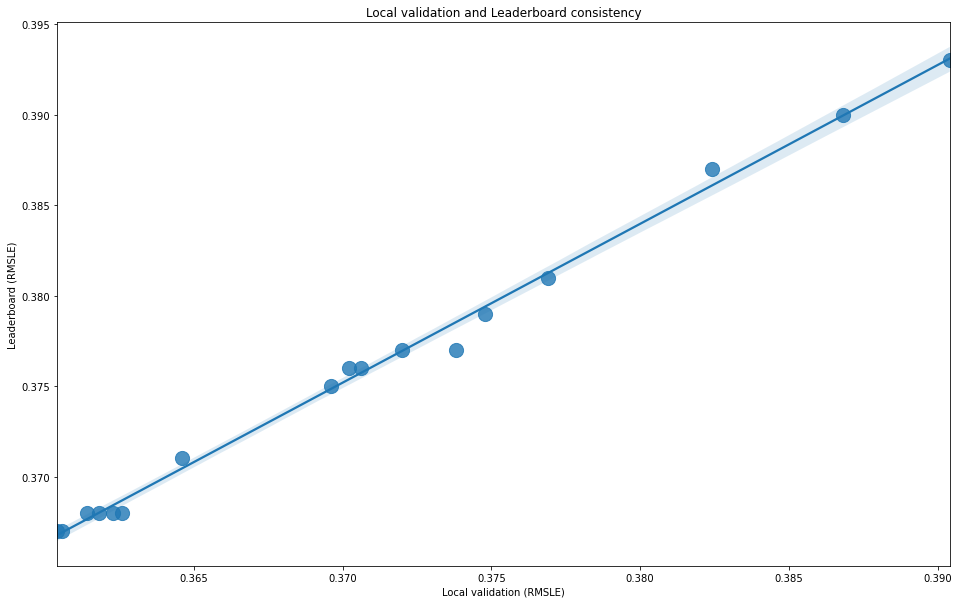

In [86]:
cv_lb = pd.DataFrame({
    'cv': [0.3604,0.36056,0.3614,0.3618,0.3623,0.3626,0.3646,0.3696,0.3702,0.3706,0.372,0.3738,0.37477,0.37691,0.3824,0.3868,0.3904],
    'lb': [0.367,0.367,0.368,0.368,0.368,0.368,0.371,0.375,0.376,0.376,0.377,0.377,0.379,0.381,0.387,0.39,0.393]})
ax = sns.regplot(x="cv", y="lb", data=cv_lb, scatter_kws={'s':200})
ax.set_xlabel('Local validation (RMSLE)')
ax.set_ylabel('Leaderboard (RMSLE)')
ax.set_title('Local validation and Leaderboard consistency')
print('CV - LB Diff: %.3f' % np.mean(cv_lb['lb'] - cv_lb['cv']))